# New Clue
In this notebook, we'll test the new, simplified CLUE implementation. We're not using Bayesian Neural Networks here, so the uncertainty is just the entropy of the classifier.

## Setup


Import libraries

In [80]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import new_CLUE
importlib.reload(new_CLUE)

<module 'new_CLUE' from '/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/ReGene/new_CLUE.py'>

Set the device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [4]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Set the latent dimension

In [5]:
latent_dim = 256

Create a models directory if it doesn't exist

In [6]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

## Load the joint-training autoencoder model

We load the model trained with a joint training objective.

In [ ]:
classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

# Load the trained models
classifier.load_state_dict(torch.load('models/joint_classifier.pth', map_location=device))
decoder.load_state_dict(torch.load('models/joint_decoder.pth', map_location=device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_43172/4034084385.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  joint_classifier.load_state_dict(torch.load('

<All keys matched successfully>

Get the most uncertain images, we need a non-shuffled loader for this.

In [ ]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all training data points
uncertainties = []
indices = []

classifier.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get latent representations and predictions
        z, logits = classifier(images)
        
        # Calculate uncertainty (entropy) for each prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        # Store uncertainties and indices
        uncertainties.extend(entropy.cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(trainset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

# Verify the most uncertain predictions
print("\nVerifying top 5 most uncertain predictions:")
classifier.eval()
with torch.no_grad():
    for i in range(5):
        idx = sorted_data_indices[i]
        image, _ = trainset[idx]
        image = image.to(device).unsqueeze(0)
        _, logits = classifier(image)
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        print(f"\nPrediction {i+1}:")
        print(f"Stored entropy: {sorted_uncertainties[i]:.3f}")
        print(f"Recalculated entropy: {entropy.item():.3f}")
        print(f"Probabilities: {probs[0].cpu().numpy().round(3)}")

print(f"\nMost uncertain predictions have entropy: {sorted_uncertainties[:5]}")
print(f"Least uncertain predictions have entropy: {sorted_uncertainties[-5:]}")


Verifying top 5 most uncertain predictions:

Prediction 1:
Stored entropy: 1.371
Recalculated entropy: 1.371
Probabilities: [0.402 0.153 0.046 0.    0.    0.    0.086 0.    0.312 0.   ]

Prediction 2:
Stored entropy: 1.271
Recalculated entropy: 1.271
Probabilities: [0.    0.274 0.    0.    0.197 0.    0.    0.024 0.458 0.046]

Prediction 3:
Stored entropy: 1.135
Recalculated entropy: 1.135
Probabilities: [0.077 0.005 0.617 0.215 0.003 0.052 0.    0.    0.    0.032]

Prediction 4:
Stored entropy: 1.056
Recalculated entropy: 1.056
Probabilities: [0.186 0.    0.    0.001 0.    0.    0.498 0.    0.31  0.005]

Prediction 5:
Stored entropy: 1.055
Recalculated entropy: 1.055
Probabilities: [0.243 0.    0.    0.    0.    0.    0.475 0.    0.282 0.   ]

Most uncertain predictions have entropy: [1.3709209 1.270649  1.1351737 1.056384  1.0553004]
Least uncertain predictions have entropy: [2.6097019e-17 1.1480115e-17 6.4684300e-18 2.3343833e-18 2.2614270e-18]


In [50]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(trainset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        trainset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = trainset[data_idx]
        
        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
        
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")
    
    plt.suptitle("Most Uncertain Predictions")
    plt.show()

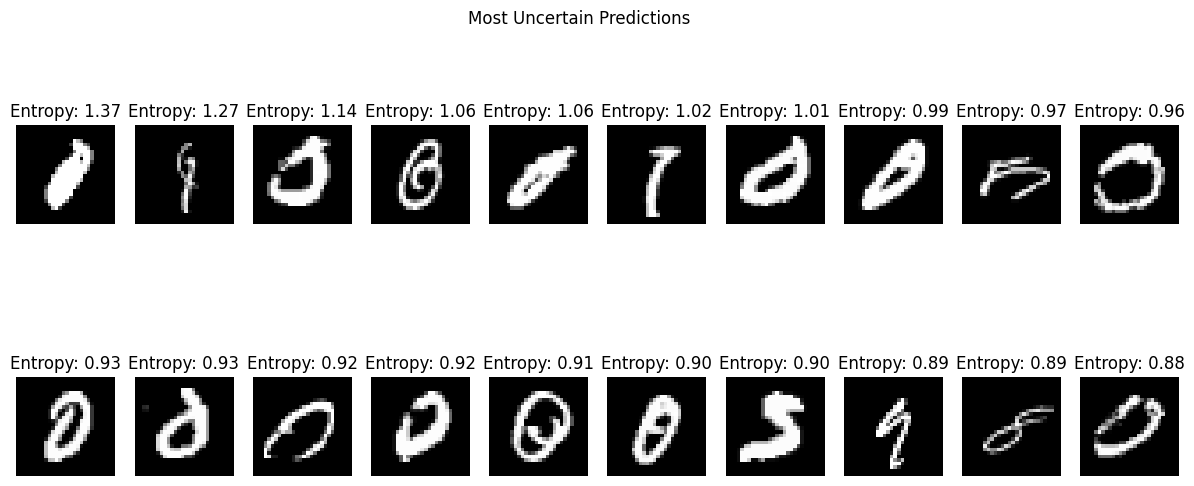

In [51]:
# Plot the most uncertain predictions
plot_most_uncertain(trainset, sorted_data_indices, sorted_uncertainties, n_plot=20)

## Test new CLUE implementation

Step 00: Loss: 1.2706, Entropy: 1.2706, Distance: 0.0000
Step 01: Loss: 0.6485, Entropy: 0.6325, Distance: 1.6000
Step 02: Loss: 0.2080, Entropy: 0.1782, Distance: 2.9774
Step 03: Loss: 0.0866, Entropy: 0.0437, Distance: 4.2846
Step 04: Loss: 0.0663, Entropy: 0.0122, Distance: 5.4093
Step 05: Loss: 0.0677, Entropy: 0.0041, Distance: 6.3582
Step 06: Loss: 0.0732, Entropy: 0.0016, Distance: 7.1597
Step 07: Loss: 0.0791, Entropy: 0.0007, Distance: 7.8395
Step 08: Loss: 0.0845, Entropy: 0.0003, Distance: 8.4177
Step 09: Loss: 0.0893, Entropy: 0.0002, Distance: 8.9101
Step 10: Loss: 0.0934, Entropy: 0.0001, Distance: 9.3289
Step 11: Loss: 0.0969, Entropy: 0.0001, Distance: 9.6839
Step 12: Loss: 0.0999, Entropy: 0.0000, Distance: 9.9832
Step 13: Loss: 0.1024, Entropy: 0.0000, Distance: 10.2334
Step 14: Loss: 0.1044, Entropy: 0.0000, Distance: 10.4402
Step 15: Loss: 0.1061, Entropy: 0.0000, Distance: 10.6084
Step 16: Loss: 0.1074, Entropy: 0.0000, Distance: 10.7422
Step 17: Loss: 0.1085, Entr

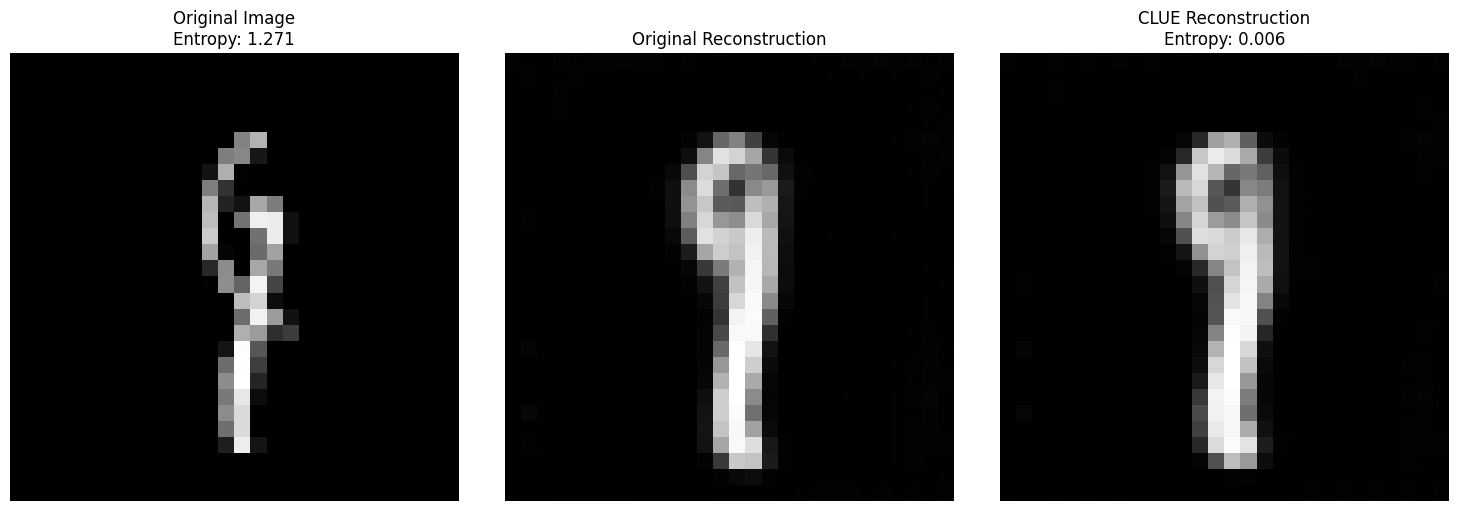


Class probabilities:
Original: [0.    0.274 0.    0.    0.197 0.    0.    0.024 0.458 0.046]
Explained: [0.    0.    0.    0.    0.    0.    0.    0.    0.999 0.   ]


In [55]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[1]
uncertain_image, _ = trainset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
classifier.eval()
with torch.no_grad():
    z0, _ = classifier(uncertain_image)

# Initialize CLUE
clue = new_CLUE.SimpleCLUE(
    classifier=classifier,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.01,
    lr=0.1,
    device=device
)

# Optimize to find explanation
z_explained = clue.optimize(steps=100)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = decoder(z0)
    # CLUE reconstruction  
    clue_recon = decoder(z_explained)
    
    # Get predictions and uncertainties
    # Use only the classifier head for the latent vectors
    original_logits = classifier.classifier(z0)
    explained_logits = classifier.classifier(z_explained)
    
    original_probs = torch.nn.functional.softmax(original_logits, dim=1)
    explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
    
    original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
    explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nEntropy: {original_entropy:.3f}')
plt.axis('off')

plt.subplot(132)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(133)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'CLUE Reconstruction\nEntropy: {explained_entropy:.3f}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print("Original:", original_probs.cpu().numpy()[0].round(3))
print("Explained:", explained_probs.cpu().numpy()[0].round(3))


Distance between original and explained points in t-SNE space: 0.054


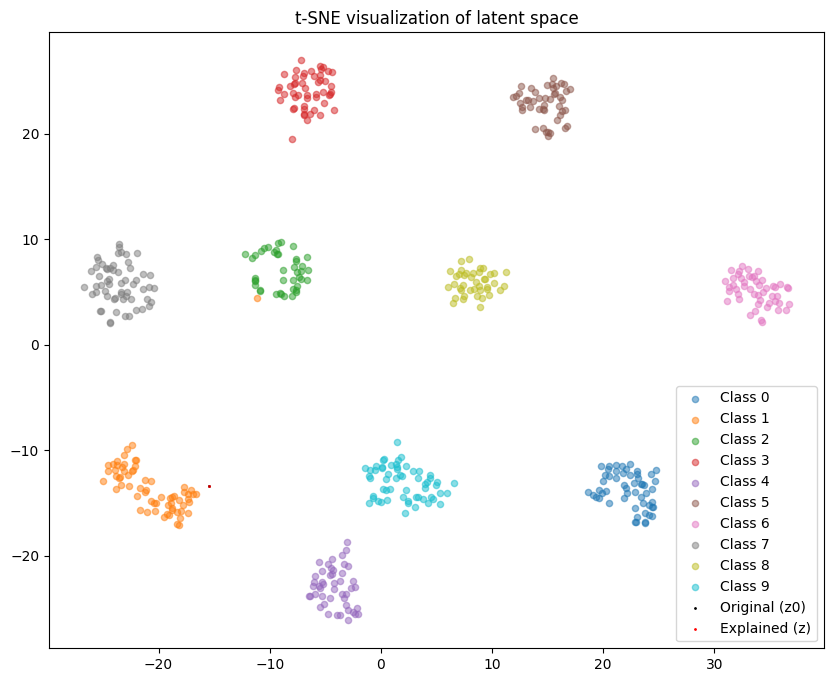

In [ ]:
# Get latent codes for 500 training images to create TSNE visualization
latent_codes = []
labels_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(trainloader):
        if i >= 500/images.shape[0]:  # Stop after ~500 images
            break
        images = images.to(device)
        z, _ = classifier(images)
        latent_codes.append(z.cpu())
        labels_list.append(labels)
latent_codes = torch.cat(latent_codes, dim=0)
labels = torch.cat(labels_list, dim=0)

# Add z0 and z_explained to the latent codes
all_latents = torch.cat([latent_codes, z0.cpu(), z_explained.cpu()], dim=0)

# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(all_latents.numpy())

# Plot t-SNE
plt.figure(figsize=(10, 8))

# Create scatter plot for each class
# Only plot the training points (excluding the last 2 points which are z0 and z_explained)
training_latents_2d = latents_2d[:-2]
for i in range(10):
    mask = labels == i
    plt.scatter(training_latents_2d[mask, 0], training_latents_2d[mask, 1], 
               alpha=0.5, label=f'Class {i}', s=20)  # Reduced point size to 20

# Plot original and explained points
plt.scatter(latents_2d[-2, 0], latents_2d[-2, 1], c='black', s=1, label='Original (z0)')
plt.scatter(latents_2d[-1, 0], latents_2d[-1, 1], c='red', s=1, label='Explained (z)')
plt.plot([latents_2d[-2, 0], latents_2d[-1, 0]], 
         [latents_2d[-2, 1], latents_2d[-1, 1]], 
         'k--', alpha=0.5)

# Calculate and print distance between original and explained points in t-SNE space
tsne_distance = np.sqrt(np.sum((latents_2d[-2] - latents_2d[-1])**2))
print(f"\nDistance between original and explained points in t-SNE space: {tsne_distance:.3f}")

plt.title('t-SNE visualization of latent space')
plt.legend()
plt.show()


## Load the SVAE

In [70]:
from importlib import reload
import SVAE
reload(SVAE)
from SVAE import SVAE

svae = SVAE(latent_dim=latent_dim, num_classes=10, device=device)
svae.load_state_dict(torch.load('models/svae.pth', map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_43172/2112457366.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svae.load_state_dict(torch.load('models/svae.

<All keys matched successfully>

Test the model on some images

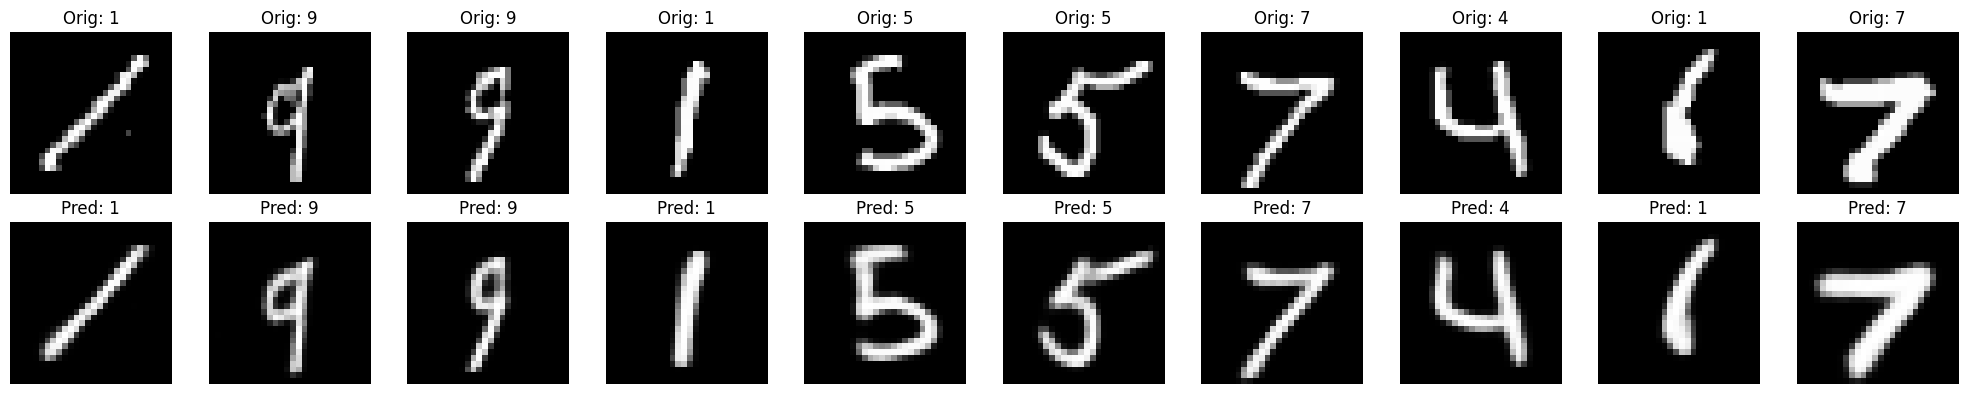

In [72]:
# Get a batch of images from the trainloader
svae.eval()
with torch.no_grad():
    # Get one batch of images
    images, labels = next(iter(trainloader))
    images = images.to(device)
    labels = labels.to(device)
    
    # Pass through SVAE
    recon_images, pred_labels, mu, log_var = svae(images)
    
    # Get predictions
    pred_classes = torch.argmax(pred_labels, dim=1)

# Plot the results
plt.figure(figsize=(20, 4))

# Plot original images
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Orig: {labels[i].item()}')
    plt.axis('off')

# Plot reconstructed images
for i in range(10):
    plt.subplot(2, 10, i+11)
    plt.imshow(recon_images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Pred: {pred_classes[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Get the most uncertain images, we need a non-shuffled loader for this.

In [75]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all training data points
uncertainties = []
indices = []

svae.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get predictions from SVAE
        _, logits, _, _ = svae(images)
        
        # Calculate uncertainty (entropy) for each prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
        
        # Store uncertainties and indices
        uncertainties.extend(entropy.cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(trainset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties_svae = uncertainties[sorted_idx]
sorted_data_indices_svae = indices[sorted_idx]

print(f"\nMost uncertain predictions have entropy: {sorted_uncertainties_svae[:5]}")
print(f"Least uncertain predictions have entropy: {sorted_uncertainties_svae[-5:]}")


Most uncertain predictions have entropy: [1.6675584 1.6327531 1.5623612 1.5163238 1.5051223]
Least uncertain predictions have entropy: [2.4574932e-08 2.1444754e-08 1.4401838e-08 1.4278193e-08 1.2204938e-08]


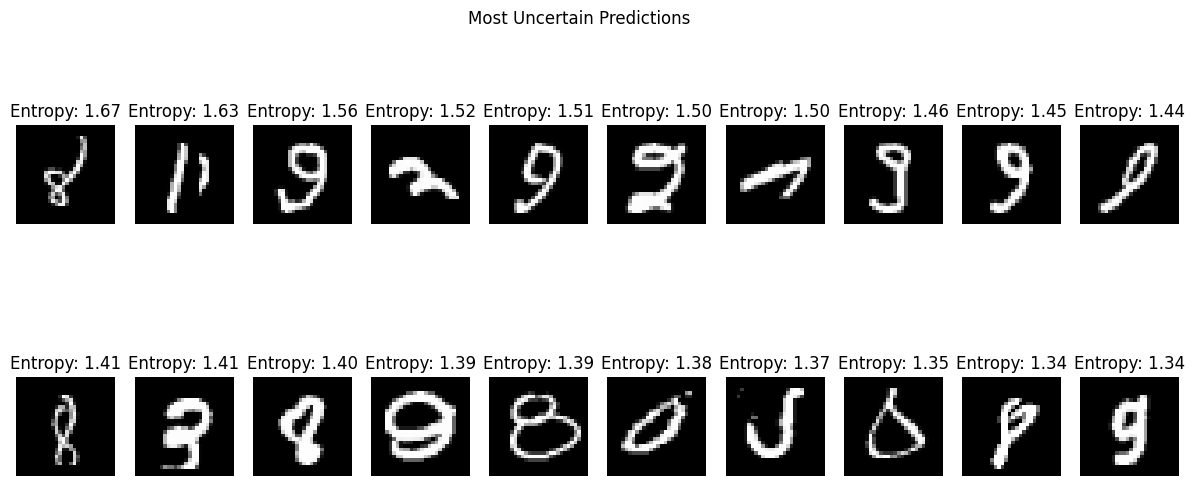

In [78]:
# Plot the most uncertain predictions
plot_most_uncertain(trainset, sorted_data_indices_svae, sorted_uncertainties_svae, n_plot=20)
plt.show()


### Apply CLUE to SVAE

A single example of a counterfactual explanation

Step 00: Loss: 1.2077, Entropy: 1.2077, Distance: 0.0000
Step 01: Loss: 0.1649, Entropy: 0.1489, Distance: 1.6000
Step 02: Loss: 0.0463, Entropy: 0.0177, Distance: 2.8582
Step 03: Loss: 0.0418, Entropy: 0.0036, Distance: 3.8121
Step 04: Loss: 0.0466, Entropy: 0.0011, Distance: 4.5515
Step 05: Loss: 0.0518, Entropy: 0.0005, Distance: 5.1369
Step 06: Loss: 0.0563, Entropy: 0.0002, Distance: 5.6061
Step 07: Loss: 0.0600, Entropy: 0.0001, Distance: 5.9844
Step 08: Loss: 0.0630, Entropy: 0.0001, Distance: 6.2895
Step 09: Loss: 0.0654, Entropy: 0.0001, Distance: 6.5346
Step 10: Loss: 0.0673, Entropy: 0.0000, Distance: 6.7297
Step 11: Loss: 0.0689, Entropy: 0.0000, Distance: 6.8826
Step 12: Loss: 0.0700, Entropy: 0.0000, Distance: 6.9996
Step 13: Loss: 0.0709, Entropy: 0.0000, Distance: 7.0857
Step 14: Loss: 0.0715, Entropy: 0.0000, Distance: 7.1448
Step 15: Loss: 0.0718, Entropy: 0.0000, Distance: 7.1803
Step 16: Loss: 0.0720, Entropy: 0.0000, Distance: 7.1949
Step 17: Loss: 0.0719, Entropy:

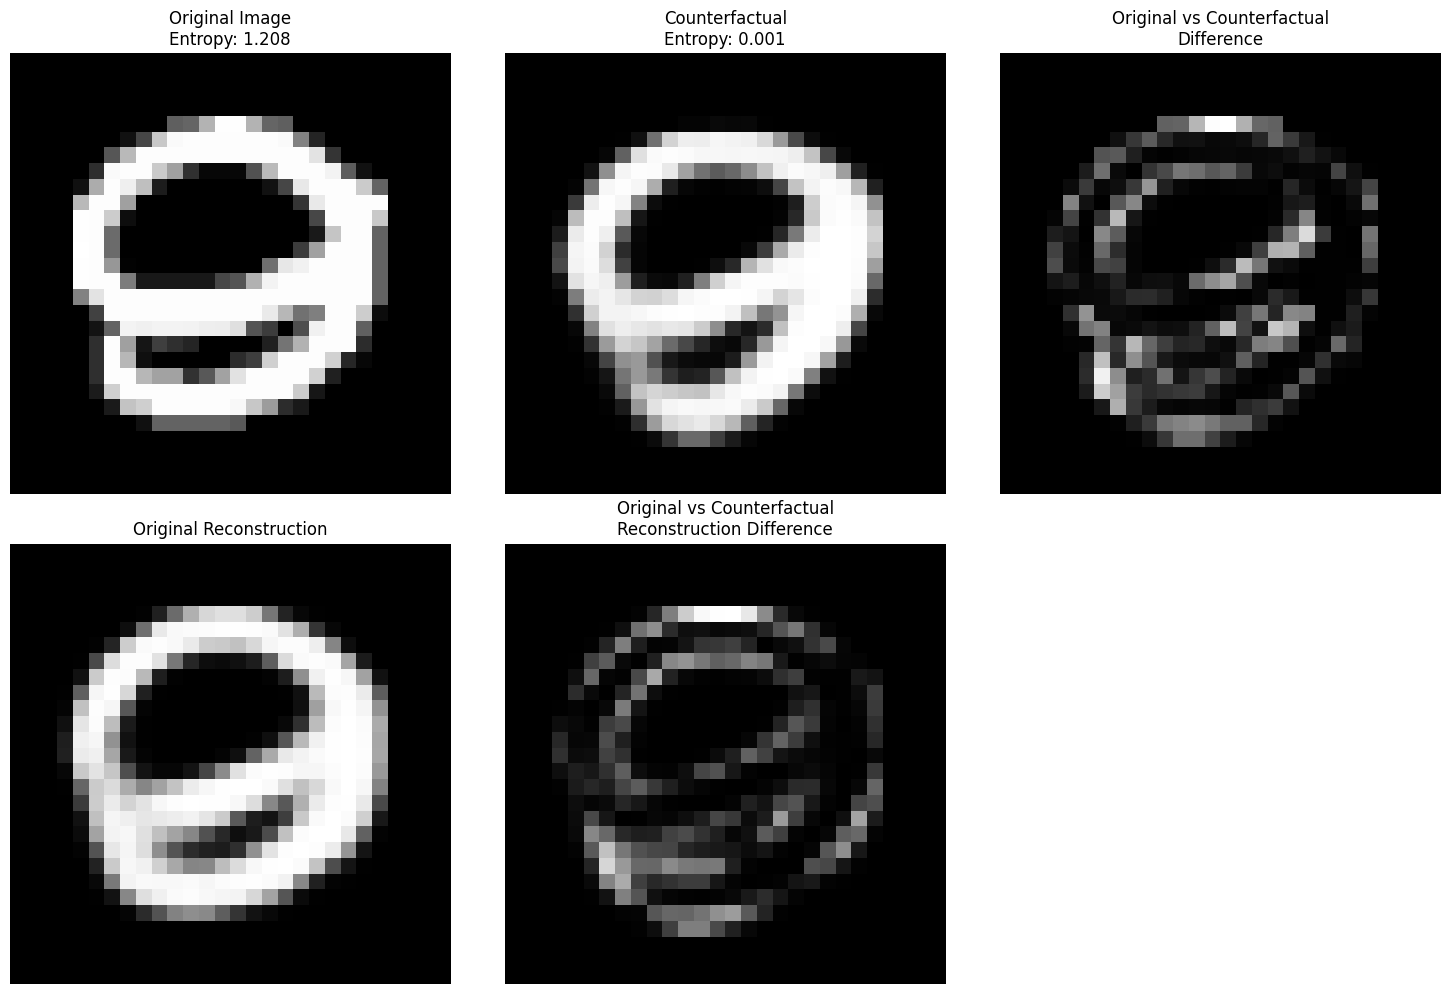


Class probabilities:
Original: [0.04  0.    0.119 0.094 0.002 0.001 0.001 0.001 0.136 0.607]
Explained: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [102]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices_svae[13]
uncertain_image, _ = trainset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
svae.eval()
with torch.no_grad():
    _, _, mu, log_var = svae(uncertain_image)
    z0 = svae.reparameterize(mu, log_var)

# Initialize CLUE
clue = new_CLUE.SimpleCLUE(
    model=svae,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.01,
    lr=0.1,
    device=device
)

# Optimize to find explanation
z_explained = clue.optimize(steps=100)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = svae.decode(z0)
    # CLUE reconstruction  
    clue_recon = svae.decode(z_explained)
    
    # Get predictions and uncertainties
    # Use only the classifier head for the latent vectors
    original_logits = svae.classifier(z0)
    explained_logits = svae.classifier(z_explained)
    
    original_probs = torch.nn.functional.softmax(original_logits, dim=1)
    explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
    
    original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
    explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nEntropy: {original_entropy:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nEntropy: {explained_entropy:.3f}')
plt.axis('off')

plt.subplot(233)
plt.imshow(torch.abs(uncertain_image[0,0].cpu() - clue_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Original vs Counterfactual\nDifference')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
plt.imshow(torch.abs(original_recon[0,0].cpu().detach() - clue_recon[0,0].cpu().detach()), cmap='gray')
plt.title('Original vs Counterfactual\nReconstruction Difference')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities
print("\nClass probabilities:")
print("Original:", original_probs.cpu().numpy()[0].round(3))
print("Explained:", explained_probs.cpu().numpy()[0].round(3))

Multiple CLUEs

Step 00: Loss: 0.6559, Entropy: 0.6559, Distance: 0.0000
Step 01: Loss: 0.0996, Entropy: 0.0676, Distance: 1.6000
Step 02: Loss: 0.0625, Entropy: 0.0096, Distance: 2.6465
Step 03: Loss: 0.0701, Entropy: 0.0021, Distance: 3.3994
Step 04: Loss: 0.0797, Entropy: 0.0006, Distance: 3.9532
Step 05: Loss: 0.0875, Entropy: 0.0002, Distance: 4.3623
Step 06: Loss: 0.0933, Entropy: 0.0001, Distance: 4.6617
Step 07: Loss: 0.0976, Entropy: 0.0001, Distance: 4.8761
Step 08: Loss: 0.1005, Entropy: 0.0000, Distance: 5.0233
Step 09: Loss: 0.1024, Entropy: 0.0000, Distance: 5.1167
Step 10: Loss: 0.1033, Entropy: 0.0000, Distance: 5.1664
Step 11: Loss: 0.1036, Entropy: 0.0000, Distance: 5.1802
Step 12: Loss: 0.1033, Entropy: 0.0000, Distance: 5.1640
Step 13: Loss: 0.1025, Entropy: 0.0000, Distance: 5.1225
Step 14: Loss: 0.1012, Entropy: 0.0000, Distance: 5.0599
Step 15: Loss: 0.0996, Entropy: 0.0000, Distance: 4.9798
Step 16: Loss: 0.0977, Entropy: 0.0000, Distance: 4.8856
Step 17: Loss: 0.0956, Entropy:

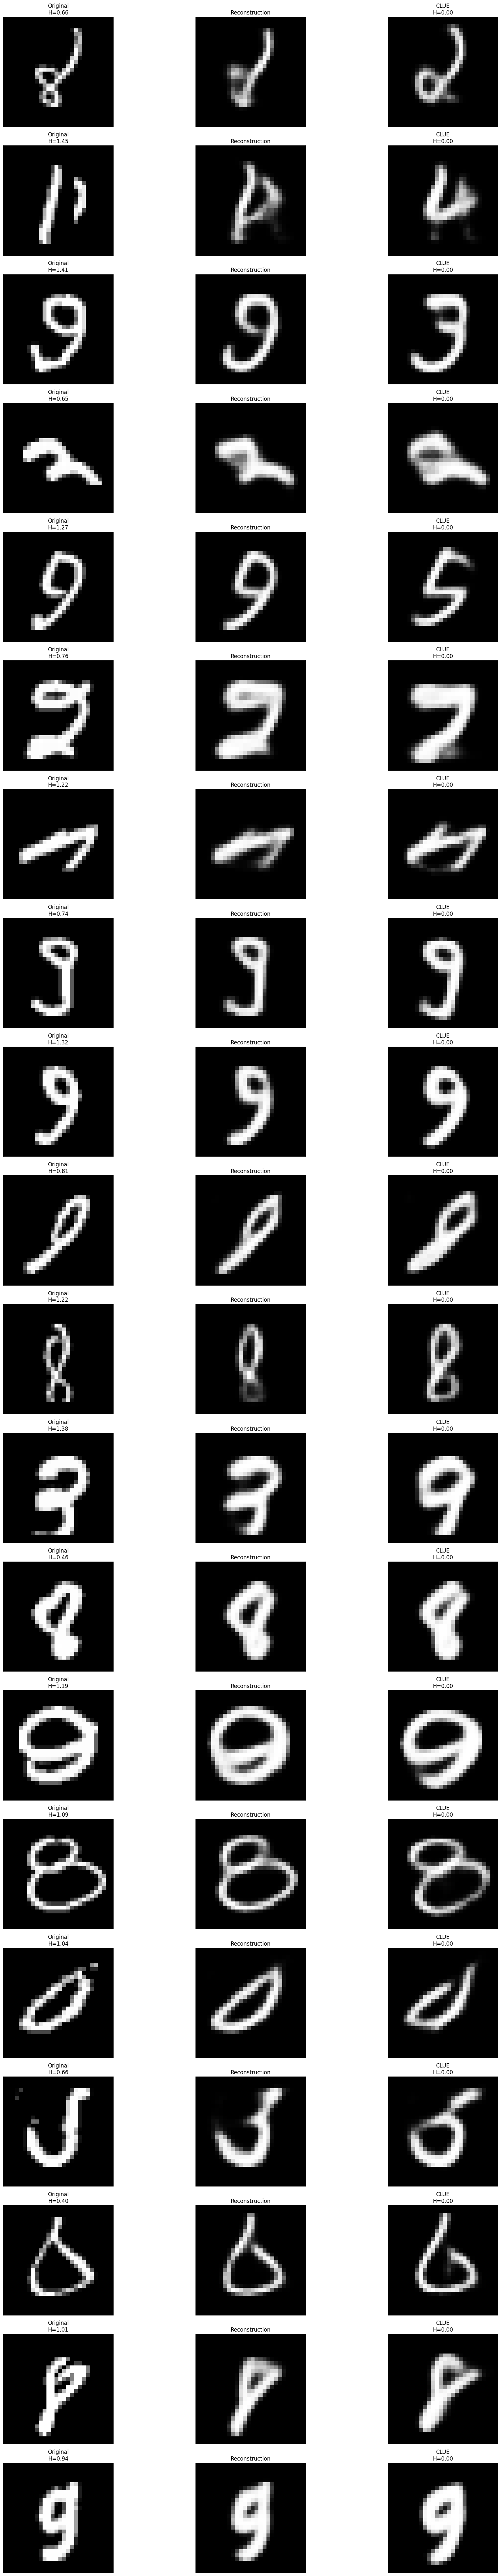


Class probabilities for last example:
Original: [0.    0.    0.    0.025 0.088 0.229 0.    0.001 0.001 0.655]
Explained: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [107]:
# Get 20 most uncertain images and generate CLUEs for each
plt.figure(figsize=(20, 80))  # Increased height significantly to give more space per row

for i in range(20):
    # Get uncertain image and its latent representation 
    uncertain_idx = sorted_data_indices_svae[i]
    uncertain_image, _ = trainset[uncertain_idx]
    uncertain_image = uncertain_image.to(device).unsqueeze(0)

    # Get latent representation
    svae.eval()
    with torch.no_grad():
        _, _, mu, log_var = svae(uncertain_image)
        z0 = svae.reparameterize(mu, log_var)

    # Initialize and run CLUE
    clue = new_CLUE.SimpleCLUE(
        model=svae,
        z0=z0,
        uncertainty_weight=1.0,
        distance_weight=0.02,
        lr=0.1,
        device=device
    )
    z_explained = clue.optimize(steps=50)

    # Generate reconstructions
    with torch.no_grad():
        original_recon = svae.decode(z0)
        clue_recon = svae.decode(z_explained)
        
        # Get predictions and uncertainties
        original_logits = svae.classifier(z0)
        explained_logits = svae.classifier(z_explained)
        original_probs = torch.nn.functional.softmax(original_logits, dim=1)
        explained_probs = torch.nn.functional.softmax(explained_logits, dim=1)
        original_entropy = -(original_probs * torch.log(original_probs + 1e-10)).sum()
        explained_entropy = -(explained_probs * torch.log(explained_probs + 1e-10)).sum()

    # Plot this example
    plt.subplot(20, 3, 3*i+1)
    plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
    plt.title(f'Original\nH={original_entropy:.2f}', fontsize=12)  # Increased font size
    plt.axis('off')

    plt.subplot(20, 3, 3*i+2)
    plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
    plt.title('Reconstruction', fontsize=12)  # Increased font size
    plt.axis('off')

    plt.subplot(20, 3, 3*i+3)
    plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
    plt.title(f'CLUE\nH={explained_entropy:.2f}', fontsize=12)  # Increased font size
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print probabilities for last example
print("\nClass probabilities for last example:")
print("Original:", original_probs.cpu().numpy()[0].round(3))
print("Explained:", explained_probs.cpu().numpy()[0].round(3))